<a href="https://colab.research.google.com/github/Alpha-mon/AI-RoboAdvisor/blob/main/Alphamon1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 야후 파이낸스 주식 정보 가져오기

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 주식 정보 가져오기
ticker = 'NVDA'
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)
data = yf.download(ticker, start=start_date, end=end_date)

closing_prices = data['Close']
volume = data['Volume']
moving_average = closing_prices.rolling(window=120).mean()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# 6개 알고리즘 전체 코드

# Bollinger

def calculate_bollinger_bands(closing_prices, window=20, num_std=2):
    rolling_mean = closing_prices.rolling(window=window).mean()
    rolling_std = closing_prices.rolling(window=window).std()

    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

upper_band, lower_band = calculate_bollinger_bands(closing_prices)
bollinger_bands_data = pd.DataFrame({'Upper Band': upper_band, 'Lower Band': lower_band})

bollinger_bands_data.dropna(inplace=True)
result = np.where(closing_prices > upper_band, (closing_prices - upper_band) / (upper_band - lower_band), np.where(closing_prices < lower_band, (closing_prices - lower_band) / (lower_band - upper_band), np.nan))
bollinger_bands_data['Result'] = pd.Series(result, index=closing_prices.index)

bollinger_bands_data['Result'].fillna(method='ffill', inplace=True)

bollinger_bands_data['Prediction'] = bollinger_bands_data['Result'].shift(-1)
bollinger_bands_data.dropna(inplace=True)
bollinger_bands_data['Trend'] = bollinger_bands_data['Prediction'].diff()
bollinger_bands_data['Trend'] = (bollinger_bands_data['Trend'] + 1) / 2

min_pred = bollinger_bands_data['Prediction'].min()
max_pred = bollinger_bands_data['Prediction'].max()
bollinger_bands_data['Prediction'] = (bollinger_bands_data['Prediction'] - min_pred) / (max_pred - min_pred)

min_trend = bollinger_bands_data['Trend'].min()
max_trend = bollinger_bands_data['Trend'].max()
bollinger_bands_data['Trend'] = (bollinger_bands_data['Trend'] - min_trend) / (max_trend - min_trend)*100

pd.set_option('display.float_format', '{:.4f}'.format)


# MACD

def calculate_macd(closing_prices):

    short_ema = closing_prices.ewm(span=26, adjust=False).mean()
    long_ema = closing_prices.ewm(span=12, adjust=False).mean()

    dif = short_ema - long_ema
    signal_line = dif.ewm(span=9, adjust=False).mean()
    histogram = dif - signal_line

    return dif, signal_line, histogram

dif, signal_line, histogram = calculate_macd(closing_prices)
macd_data = pd.DataFrame({'DIF': dif, 'Signal Line': signal_line, 'Histogram': histogram})
macd_data['Result'] = np.where(macd_data['DIF'] > macd_data['Signal Line'], 1, 0)

macd_data['Result'] = (macd_data['Result'].rolling(window=20, min_periods=1).mean())*100
macd_data['Prediction'] = macd_data['Result'].shift(-1)
macd_data.dropna(inplace=True)

# MOK

def calculate_mok(closing_prices, period=14, ma_period=20):
    returns = closing_prices.pct_change()

    moving_average = closing_prices.rolling(window=ma_period).mean()
    momentum = closing_prices.diff(period)
    normalized_momentum = 100 * (momentum - np.min(momentum)) / (np.max(momentum) - np.min(momentum))

    return normalized_momentum

mok_values = calculate_mok(closing_prices)

# RSI

def calculate_rsi(closing_prices, window=20):
    price_changes = closing_prices.diff()
    up_changes = price_changes.where(price_changes > 0, 0)
    down_changes = -price_changes.where(price_changes < 0, 0)

    avg_up_changes = up_changes.rolling(window=window, min_periods=1).mean()
    avg_down_changes = down_changes.rolling(window=window, min_periods=1).mean()

    rs = avg_up_changes / avg_down_changes
    rsi = 100 - (100 / (1 + rs))

    return rsi

rsi_result = calculate_rsi(closing_prices, window=len(closing_prices)//10)  # 기간을 데이터의 1/10로 동적으로 설정
rsi_result.dropna(inplace=True)

# STCK

def calculate_stck(closing_prices, window=20):
    lowest_low = closing_prices.rolling(window=window).min()
    highest_high = closing_prices.rolling(window=window).max()

    stck = 100 * (closing_prices - lowest_low) / (highest_high - lowest_low)

    stck_ma = stck.rolling(window=20).mean()

    return stck_ma

stck_result = calculate_stck(closing_prices)
stck_result.dropna(inplace=True)

# WR

def calculate_williams_r(closing_prices, period=14):
    high_prices = data['High']
    low_prices = data['Low']
    moving_average = closing_prices.rolling(window=20).mean()

    highest_high = high_prices.rolling(window=period).max()
    lowest_low = low_prices.rolling(window=period).min()

    williams_r = (highest_high - moving_average) / (highest_high - lowest_low) * -100

    normalized_williams_r = 100 * (williams_r + 100) / 100

    return normalized_williams_r

wr_result = calculate_williams_r(closing_prices)

In [ ]:
# 6개 지표들을 하나의 데이터 프레임에 합치기

final_df = pd.DataFrame({
    'Bollinger': bollinger_bands_data['Trend'],
    'MACD': macd_data['Prediction'],
    'MOK': mok_values,
    'RSI': rsi_result,
    'STCK': stck_result,
    'WR': wr_result
})

# NaN 값을 제거합니다.
final_df.dropna(inplace=True)
# 최종 데이터 프레임 출력
print(final_df)

            Bollinger    MACD     MOK     RSI    STCK      WR
Date                                                         
2014-02-13    43.8505 55.0000 40.3087 56.0362 50.1006 27.0795
2014-02-14    28.7469 55.0000 40.3868 57.5436 51.5429 25.5513
2014-02-18    42.4711 55.0000 40.3676 57.5078 53.3726 28.8534
2014-02-19    51.9447 55.0000 40.4145 58.1338 54.9226 29.2618
2014-02-20    47.6999 55.0000 40.4602 59.7165 56.5726 28.8429
...               ...     ...     ...     ...     ...     ...
2023-10-04    47.6999 80.0000 32.6874 59.5827 25.8739 59.6536
2023-10-05    47.6999 75.0000 43.8813 59.7339 26.7274 63.8320
2023-10-06    47.6999 70.0000 48.7282 60.0288 28.9526 55.8796
2023-10-09    47.6999 65.0000 48.5214 60.2380 31.8860 55.9784
2023-10-10    47.6999 60.0000 57.2054 60.5174 35.5890 51.8735

[2431 rows x 6 columns]


In [ ]:
# LSTM 모델

final_df_values = final_df.values
data_values = data.values

# 입력 시퀀스에 대한 타임 스텝(T)을 정의합니다.

T = 10  # 원하는대로 조정할 수 있습니다.

# 입력 및 타겟을 위한 데이터 시퀀스 생성
final_df_sequences = []
data_sequences = []

for i in range(len(data_values) - T):
    final_df_sequences.append(final_df_values[i:i+T])
    data_sequences.append(closing_prices.iloc[i+T])

filtered_final_df_sequences = []
filtered_data_sequences = []

# 시퀀스 길이 맞추기
for i, seq in enumerate(final_df_sequences):
    if len(seq) == 10:
        filtered_final_df_sequences.append(seq)
        filtered_data_sequences.append(data_sequences[i])

final_df_sequences = filtered_final_df_sequences
data_sequences = filtered_data_sequences

# 시퀀스를 넘파이 배열로 변환
X = np.array(final_df_sequences)
y = np.array(data_sequences)


# 데이터를 훈련 및 테스트 세트로 분할
split_ratio = 0.8  # 분할 비율을 조정할 수 있습니다.
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# LSTM 모델 구축
model = Sequential()

# 첫 번째 LSTM 레이어 (시퀀스 출력을 반환하여 다음 레이어로 전달)
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(T, 6)))

# 두 번째 LSTM 레이어
model.add(LSTM(50, activation='relu', return_sequences=True))

# 세 번째 LSTM 레이어 (시퀀스 출력을 반환하지 않음)
model.add(LSTM(50, activation='relu'))

# 출력 레이어
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')


# 모델 훈련
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 테스트 데이터에서 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# 예측 수행
predictions = model.predict(X_test)
print(predictions)

# 예측 결과를 데이터 프레임으로 변환
predictions_df = pd.DataFrame(predictions, columns=["Predictions"])
print(predictions_df)

Epoch 1/10
49/49 [==============================] - 6s 31ms/step - loss: 504.8314 - val_loss: 8547.4258
Epoch 2/10
49/49 [==============================] - 2s 34ms/step - loss: 403.3673 - val_loss: 9506.1572
Epoch 3/10
49/49 [==============================] - 2s 32ms/step - loss: 380.6676 - val_loss: 9572.8760
Epoch 4/10
49/49 [==============================] - 1s 23ms/step - loss: 349.2497 - val_loss: 9695.2969
Epoch 5/10
49/49 [==============================] - 1s 20ms/step - loss: 313.1483 - val_loss: 10939.1572
Epoch 6/10
49/49 [==============================] - 1s 20ms/step - loss: 317.0918 - val_loss: 9302.9932
Epoch 7/10
49/49 [==============================] - 1s 25ms/step - loss: 291.0522 - val_loss: 9176.7188
Epoch 8/10
49/49 [==============================] - 1s 24ms/step - loss: 311.4862 - val_loss: 8884.0010
Epoch 9/10
49/49 [==============================] - 1s 20ms/step - loss: 263.8724 - val_loss: 9107.6924
Epoch 10/10
16/16 [==============================] - 0s 6ms/ste

In [ ]:
# LSTM 모델의 예측 값을 6개 지표 값과 함께 생성 모델 입력값으로 넣기 위해

# T 타임 스텝 만큼의 길이를 고려하여 LSTM 예측값을 올바른 위치에 넣습니다.
final_df["LSTM_Predictions"] = np.nan
final_df["LSTM_Predictions"].iloc[-len(predictions_df):] = predictions_df["Predictions"].values

# NaN 값을 제거합니다.
final_df.dropna(inplace=True)

# 다시 시퀀스로 변환
final_df_values = final_df.values

final_df_sequences = []
for i in range(len(data_values) - T):
    final_df_sequences.append(final_df_values[i:i+T])

X = np.array(final_df_sequences)


<ipython-input-10-7b743ab9e2f2>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(final_df_sequences)


In [ ]:
# 생성 / 구분 모델

from tensorflow.keras.layers import Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 생성 모델 G (주식 가격의 시퀀스를 생성)
def build_generator(input_shape=(T, 7)):  # 입력 값 : LSTM 모델 예측 + 6개 지표 값
    model = Sequential()

    # LSTM 레이어와 BatchNormalization, LeakyReLU 활성화 함수를 이용하여 시퀀스를 학습
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # Flatten layer를 제거하고, T 길이의 시퀀스를 생성하도록 수정
    model.add(LSTM(128))
    model.add(Dense(T, activation='linear'))

    noise = tf.keras.layers.Input(shape=input_shape)
    generated_sequence = model(noise)

    return Model(noise, generated_sequence)

# 구분 모델 D (주가의 실제 시퀀스와 생성된 시퀀스를 구분)
def build_discriminator(input_shape=(T, 1)):
    model = Sequential()

    # LSTM 레이어와 LeakyReLU 활성화 함수를 사용하여 시퀀스를 처리
    model.add(LSTM(128, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    sequence = tf.keras.layers.Input(shape=input_shape)
    validity = model(sequence)

    # 주어진 시퀀스가 실제인지 생성된 것인지에 대한 확률
    return Model(sequence, validity)

In [ ]:
# 학습 함수 (생성된 주식 가격 시퀀스와 실제 주식 가격 시퀀스를 사용하여 판별자를 학습)

def train_gan(generator, discriminator, combined, epochs, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        sequences = X_train[idx]

        # 주식 예측값 생성
        predicted_stock = model.predict(sequences)

        # LSTM 예측값을 sequences에 추가
        predicted_stock_reshaped = predicted_stock.reshape(batch_size, 1, 1)  # (batch_size, 1, 1) 형태로 변환
        predicted_stock_expanded = np.repeat(predicted_stock_reshaped, T, axis=1)  # predicted_stock_reshaped를 T 타임 스텝만큼 확장
        X_train_combined = np.concatenate([sequences, predicted_stock_expanded], axis=2)

        generated_stock = generator.predict(X_train_combined)
        generated_stock_reshaped = generated_stock.reshape(batch_size, T, 1)

        # 판별자 학습
        d_loss_real = discriminator.train_on_batch(predicted_stock_expanded, valid)
        d_loss_fake = discriminator.train_on_batch(generated_stock_reshaped, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 생성자 학습
        g_loss = combined.train_on_batch(X_train_combined, valid)

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

In [ ]:
# 판별자 및 생성자 모델 초기화, 생성자와 판별자를 결합하여

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator()
z = tf.keras.layers.Input(shape=(T, 7))
generated_sequence = generator(z)

discriminator.trainable = False
validity = discriminator(generated_sequence)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

#학습 시작
train_gan(generator, discriminator, combined, epochs=10, batch_size=32)

# 학습 후 최종 예측을 수행하는 함수
def final_predictions(generator, test_data, batch_size=32):
    predicted_stock_lstm = model.predict(test_data)

    # LSTM 예측값을 test_data에 추가
    predicted_stock_expanded = np.repeat(predicted_stock_lstm[:, np.newaxis], T, axis=1)  # (batch_size, T)로 형태 변경
    test_data_combined = np.concatenate([test_data, predicted_stock_expanded], axis=2)

    # G 모델을 사용하여 합성 주가를 생성
    generated_stock = generator.predict(test_data_combined)

    # LSTM 예측과 G 모델의 예측을 평균
    final_predicted_stock = (predicted_stock_lstm + generated_stock.mean(axis=1)) / 2.0

    return final_predicted_stock

#학습 후 최종 예측
after_gan_predictions = final_predictions(generator, X_test, batch_size=32)

# 결과 출력
print(after_gan_predictions)

average_prediction = np.mean(after_gan_predictions)
print(average_prediction)

1/1 [==============================] - 1s 848ms/step
0/10 [D loss: 0.6527732610702515 | D accuracy: 51.5625] [G loss: 0.6945138573646545]
1/1 [==============================] - 0s 33ms/step
1/10 [D loss: 0.6584954559803009 | D accuracy: 78.125] [G loss: 0.6950043439865112]
1/1 [==============================] - 0s 33ms/step
2/10 [D loss: 0.6436459124088287 | D accuracy: 98.4375] [G loss: 0.6960358619689941]
1/1 [==============================] - 0s 33ms/step
3/10 [D loss: 0.6232345700263977 | D accuracy: 100.0] [G loss: 0.6969425678253174]
1/1 [==============================] - 0s 34ms/step
4/10 [D loss: 0.618502289056778 | D accuracy: 100.0] [G loss: 0.6974769830703735]
1/1 [==============================] - 0s 35ms/step
5/10 [D loss: 0.6075031459331512 | D accuracy: 100.0] [G loss: 0.6976855993270874]
1/1 [==============================] - 0s 44ms/step
6/10 [D loss: 0.5987242460250854 | D accuracy: 100.0] [G loss: 0.6983477473258972]
1/1 [==============================] - 0s 32ms/ste

In [ ]:
# 주가 예측 전체 코드

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 주식 정보 가져오기
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)
data = yf.download(ticker, start=start_date, end=end_date)

closing_prices = data['Close']
volume = data['Volume']
moving_average = closing_prices.rolling(window=120).mean()


# Bollinger Bands 계산 함수

def calculate_bollinger_bands(closing_prices, window=20, num_std=2):
    rolling_mean = closing_prices.rolling(window=window).mean()
    rolling_std = closing_prices.rolling(window=window).std()

    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

upper_band, lower_band = calculate_bollinger_bands(closing_prices)
bollinger_bands_data = pd.DataFrame({'Upper Band': upper_band, 'Lower Band': lower_band})

bollinger_bands_data.dropna(inplace=True)
result = np.where(closing_prices > upper_band, (closing_prices - upper_band) / (upper_band - lower_band), np.where(closing_prices < lower_band, (closing_prices - lower_band) / (lower_band - upper_band), np.nan))
bollinger_bands_data['Result'] = pd.Series(result, index=closing_prices.index)

bollinger_bands_data['Result'].fillna(method='ffill', inplace=True)

bollinger_bands_data['Prediction'] = bollinger_bands_data['Result'].shift(-1)
bollinger_bands_data.dropna(inplace=True)
bollinger_bands_data['Trend'] = bollinger_bands_data['Prediction'].diff()
bollinger_bands_data['Trend'] = (bollinger_bands_data['Trend'] + 1) / 2

min_pred = bollinger_bands_data['Prediction'].min()
max_pred = bollinger_bands_data['Prediction'].max()
bollinger_bands_data['Prediction'] = (bollinger_bands_data['Prediction'] - min_pred) / (max_pred - min_pred)

min_trend = bollinger_bands_data['Trend'].min()
max_trend = bollinger_bands_data['Trend'].max()
bollinger_bands_data['Trend'] = (bollinger_bands_data['Trend'] - min_trend) / (max_trend - min_trend)*100

pd.set_option('display.float_format', '{:.4f}'.format)


# MACD 계산 함수

def calculate_macd(closing_prices):

    short_ema = closing_prices.ewm(span=26, adjust=False).mean()
    long_ema = closing_prices.ewm(span=12, adjust=False).mean()

    dif = short_ema - long_ema
    signal_line = dif.ewm(span=9, adjust=False).mean()
    histogram = dif - signal_line

    return dif, signal_line, histogram

dif, signal_line, histogram = calculate_macd(closing_prices)
macd_data = pd.DataFrame({'DIF': dif, 'Signal Line': signal_line, 'Histogram': histogram})
macd_data['Result'] = np.where(macd_data['DIF'] > macd_data['Signal Line'], 1, 0)

macd_data['Result'] = (macd_data['Result'].rolling(window=20, min_periods=1).mean())*100
macd_data['Prediction'] = macd_data['Result'].shift(-1)
macd_data.dropna(inplace=True)

# MOK

def calculate_mok(closing_prices, period=14, ma_period=20):
    returns = closing_prices.pct_change()

    moving_average = closing_prices.rolling(window=ma_period).mean()
    momentum = closing_prices.diff(period)
    normalized_momentum = 100 * (momentum - np.min(momentum)) / (np.max(momentum) - np.min(momentum))

    return normalized_momentum

mok_values = calculate_mok(closing_prices)

# RSI

def calculate_rsi(closing_prices, window=20):
    price_changes = closing_prices.diff()
    up_changes = price_changes.where(price_changes > 0, 0)
    down_changes = -price_changes.where(price_changes < 0, 0)

    avg_up_changes = up_changes.rolling(window=window, min_periods=1).mean()
    avg_down_changes = down_changes.rolling(window=window, min_periods=1).mean()

    rs = avg_up_changes / avg_down_changes
    rsi = 100 - (100 / (1 + rs))

    return rsi

rsi_result = calculate_rsi(closing_prices, window=len(closing_prices)//10)  # 기간을 데이터의 1/10로 동적으로 설정
rsi_result.dropna(inplace=True)

# STCK

def calculate_stck(closing_prices, window=20):
    lowest_low = closing_prices.rolling(window=window).min()
    highest_high = closing_prices.rolling(window=window).max()

    stck = 100 * (closing_prices - lowest_low) / (highest_high - lowest_low)

    stck_ma = stck.rolling(window=20).mean()

    return stck_ma

stck_result = calculate_stck(closing_prices)
stck_result.dropna(inplace=True)

# WR

def calculate_williams_r(closing_prices, period=14):
    high_prices = data['High']
    low_prices = data['Low']
    moving_average = closing_prices.rolling(window=20).mean()

    highest_high = high_prices.rolling(window=period).max()
    lowest_low = low_prices.rolling(window=period).min()

    williams_r = (highest_high - moving_average) / (highest_high - lowest_low) * -100

    normalized_williams_r = 100 * (williams_r + 100) / 100

    return normalized_williams_r

wr_result = calculate_williams_r(closing_prices)


# 6개 지표들을 하나의 데이터 프레임에 합치기

final_df = pd.DataFrame({
    'Bollinger': bollinger_bands_data['Trend'],
    'MACD': macd_data['Prediction'],
    'MOK': mok_values,
    'RSI': rsi_result,
    'STCK': stck_result,
    'WR': wr_result
})

# NaN 값을 제거합니다.
final_df.dropna(inplace=True)
# 최종 데이터 프레임 출력
print(final_df)


final_df_values = final_df.values
data_values = data.values

# 입력 시퀀스에 대한 타임 스텝(T)을 정의합니다.

T = 10  # 원하는대로 조정할 수 있습니다.

# 입력 및 타겟을 위한 데이터 시퀀스 생성
final_df_sequences = []
data_sequences = []

for i in range(len(data_values) - T):
    final_df_sequences.append(final_df_values[i:i+T])
    data_sequences.append(closing_prices.iloc[i+T])

filtered_final_df_sequences = []
filtered_data_sequences = []

# 시퀀스 길이 맞추기
for i, seq in enumerate(final_df_sequences):
    if len(seq) == 10:
        filtered_final_df_sequences.append(seq)
        filtered_data_sequences.append(data_sequences[i])

final_df_sequences = filtered_final_df_sequences
data_sequences = filtered_data_sequences

# 시퀀스를 넘파이 배열로 변환
X = np.array(final_df_sequences)
y = np.array(data_sequences)


# 데이터를 훈련 및 테스트 세트로 분할
split_ratio = 0.8  # 분할 비율을 조정할 수 있습니다.
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(T, 6)))  # num_features는 지표의 수입니다.
model.add(Dense(1))  # 주식 가격 예측을 위한 뉴런 하나를 가진 출력 레이어

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')


# 모델 훈련
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 테스트 데이터에서 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# 예측 수행
predictions = model.predict(X_test)
#print(predictions)

# 예측 결과를 데이터 프레임으로 변환
predictions_df = pd.DataFrame(predictions, columns=["Predictions"])
print(predictions_df)

# LSTM 모델의 예측 값을 6개 지표 값과 함께 생성 모델 입력값으로 넣기 위해

# T 타임 스텝 만큼의 길이를 고려하여 LSTM 예측값을 올바른 위치에 넣습니다.
final_df["LSTM_Predictions"] = np.nan
final_df["LSTM_Predictions"].iloc[-len(predictions_df):] = predictions_df["Predictions"].values

# NaN 값을 제거합니다.
final_df.dropna(inplace=True)

# 다시 시퀀스로 변환
final_df_values = final_df.values

final_df_sequences = []
for i in range(len(data_values) - T):
    final_df_sequences.append(final_df_values[i:i+T])

X = np.array(final_df_sequences)

# 생성 / 구분 모델

from tensorflow.keras.layers import Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 생성 모델 G (주식 가격의 시퀀스를 생성)
def build_generator(input_shape=(T, 7)):  # 입력 값 : LSTM 모델 예측 + 6개 지표 값
    model = Sequential()

    # LSTM 레이어와 BatchNormalization, LeakyReLU 활성화 함수를 이용하여 시퀀스를 학습
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # Flatten layer를 제거하고, T 길이의 시퀀스를 생성하도록 수정
    model.add(LSTM(128))
    model.add(Dense(T, activation='linear'))

    noise = tf.keras.layers.Input(shape=input_shape)
    generated_sequence = model(noise)

    return Model(noise, generated_sequence)

# 구분 모델 D (주가의 실제 시퀀스와 생성된 시퀀스를 구분)
def build_discriminator(input_shape=(T, 1)):
    model = Sequential()

    # LSTM 레이어와 LeakyReLU 활성화 함수를 사용하여 시퀀스를 처리
    model.add(LSTM(128, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    sequence = tf.keras.layers.Input(shape=input_shape)
    validity = model(sequence)

    # 주어진 시퀀스가 실제인지 생성된 것인지에 대한 확률
    return Model(sequence, validity)

# GAN 학습 함수 (생성된 주식 가격 시퀀스와 실제 주식 가격 시퀀스를 사용하여 판별자를 학습)
def train_gan(generator, discriminator, combined, epochs, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        sequences = X_train[idx]

        # 주식 예측값 생성
        predicted_stock = model.predict(sequences)

        # LSTM 예측값을 sequences에 추가
        predicted_stock_reshaped = predicted_stock.reshape(batch_size, 1, 1)  # (batch_size, 1, 1) 형태로 변환
        predicted_stock_expanded = np.repeat(predicted_stock_reshaped, T, axis=1)  # predicted_stock_reshaped를 T 타임 스텝만큼 확장
        X_train_combined = np.concatenate([sequences, predicted_stock_expanded], axis=2)

        generated_stock = generator.predict(X_train_combined)
        generated_stock_reshaped = generated_stock.reshape(batch_size, T, 1)

        # 판별자 학습
        d_loss_real = discriminator.train_on_batch(predicted_stock_expanded, valid)
        d_loss_fake = discriminator.train_on_batch(generated_stock_reshaped, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 생성자 학습
        g_loss = combined.train_on_batch(X_train_combined, valid)

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")


# 판별자 및 생성자 모델 초기화, 생성자와 판별자를 결합하여 GAN 모델 만들
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator()
z = tf.keras.layers.Input(shape=(T, 7))
generated_sequence = generator(z)

discriminator.trainable = False
validity = discriminator(generated_sequence)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# GAN 학습 시작
train_gan(generator, discriminator, combined, epochs=10, batch_size=32)

# GAN 학습 후 최종 예측을 수행하는 함수
def final_predictions(generator, test_data, batch_size=32):
    predicted_stock_lstm = model.predict(test_data)

    # LSTM 예측값을 test_data에 추가
    predicted_stock_expanded = np.repeat(predicted_stock_lstm[:, np.newaxis], T, axis=1)  # (batch_size, T)로 형태 변경
    test_data_combined = np.concatenate([test_data, predicted_stock_expanded], axis=2)

    # G 모델을 사용하여 합성 주가를 생성
    generated_stock = generator.predict(test_data_combined)

    # LSTM 예측과 G 모델의 예측을 평균
    final_predicted_stock = (predicted_stock_lstm + generated_stock.mean(axis=1)) / 2.0

    return final_predicted_stock

# GAN 학습 후 최종 예측
after_gan_predictions = final_predictions(generator, X_test, batch_size=32)

# 결과 출력
print(after_gan_predictions)

average_prediction = np.mean(after_gan_predictions)
print(average_prediction)

[*********************100%%**********************]  1 of 1 completed
            Bollinger    MACD     MOK     RSI    STCK      WR
Date                                                         
2013-12-06    47.4883 60.0000 54.5310 65.5699 70.6979 34.4688
2013-12-09    47.4883 55.0000 55.4552 66.6116 72.1410 38.1999
2013-12-10    47.4883 50.0000 55.3249 66.3360 73.8539 41.9822
2013-12-11    47.4883 45.0000 55.3510 65.0548 75.1676 45.3457
2013-12-12    47.4883 40.0000 54.8473 64.8099 76.5296 44.1786
...               ...     ...     ...     ...     ...     ...
2023-10-04    47.4883 80.0000 47.7812 52.8057 13.6627 60.1780
2023-10-05    47.4883 80.0000 51.7933 52.8968 15.0374 59.0812
2023-10-06    47.4883 80.0000 51.0233 53.2469 17.6592 58.7956
2023-10-09    47.4883 75.0000 51.8338 53.9705 20.9058 58.6424
2023-10-10    47.4883 70.0000 57.8723 53.8735 24.7798 59.4091

[2477 rows x 6 columns]
Epoch 1/10
50/50 [==============================] - 2s 13ms/step - loss: 288.5013 - val_loss: 5907.2

<ipython-input-14-74ded9a2326e>:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(final_df_sequences)


1/1 [==============================] - 1s 1s/step
0/10 [D loss: 0.749887079000473 | D accuracy: 45.3125] [G loss: 0.6953793168067932]
1/1 [==============================] - 0s 33ms/step
1/10 [D loss: 0.7350181043148041 | D accuracy: 50.0] [G loss: 0.696094274520874]
1/1 [==============================] - 0s 31ms/step
2/10 [D loss: 0.7098847925662994 | D accuracy: 50.0] [G loss: 0.6962449550628662]
1/1 [==============================] - 0s 31ms/step
3/10 [D loss: 0.6899526715278625 | D accuracy: 82.8125] [G loss: 0.6970466375350952]
1/1 [==============================] - 0s 31ms/step
4/10 [D loss: 0.674744725227356 | D accuracy: 98.4375] [G loss: 0.6967859268188477]
1/1 [==============================] - 0s 33ms/step
5/10 [D loss: 0.6626344323158264 | D accuracy: 96.875] [G loss: 0.6973535418510437]
1/1 [==============================] - 0s 34ms/step
6/10 [D loss: 0.6468399465084076 | D accuracy: 98.4375] [G loss: 0.6977488994598389]
1/1 [==============================] - 0s 31ms/step
7

In [ ]:
# 인기 주식 검색 목록 -> 분마다 새로운 값으로 자동 업데이트
# 주식 이름과 순위 변동을 출력

# 1. 필요한 라이브러리 설치
!pip install beautifulsoup4 pandas

import requests
from bs4 import BeautifulSoup
import time
import pandas as pd

# 웹 크롤링을 위한 함수 정의
def get_naver_stock_list():
    URL = "https://finance.naver.com/sise/lastsearch2.nhn"  # 네이버 증권 인기검색주식 URL

    response = requests.get(URL)
    soup = BeautifulSoup(response.text, 'html.parser')

    stock_list = []

    for item in soup.select("a.tltle"):
        stock_list.append(item.text)

    return stock_list

prev_stock_list = []  # 이전 주식 리스트 초기화

# 주기적인 데이터 수집 및 처리
while True:
    stocks = get_naver_stock_list()
    top_10_stocks = stocks[:10]  # 처음 10개의 주식만 선택

    rank_changes = []
    for stock in top_10_stocks:
        if stock in prev_stock_list:
            # 순위의 변화 계산
            rank_changes.append(prev_stock_list.index(stock) - top_10_stocks.index(stock))
        else:
            # 새롭게 진입한 주식은 0으로 처리
            rank_changes.append(0)

    # 데이터 프레임으로 변환
    df = pd.DataFrame({
        'Stock Name': top_10_stocks,
        'Rank Change': rank_changes
    })
    print(df)

    prev_stock_list = top_10_stocks.copy()  # 현재 주식 리스트를 이전 주식 리스트로 저장

    time.sleep(60)  # 매 분마다 데이터 수집

ERROR: Operation cancelled by user
  Stock Name  Rank Change
0       삼성전자            0
1       에코프로            0
2     에코프로비엠            0
3   LG에너지솔루션            0
4   POSCO홀딩스            0
5     두산로보틱스            0
6      동운아나텍            0
7     포스코퓨처엠            0
8     신성델타테크            0
9       신신제약            0


KeyboardInterrupt: ignored

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 37.1 MB/s eta 0:00:00


In [ ]:
# 뉴스 제목, 일자 크롤링 성공

import requests
from bs4 import BeautifulSoup
import datetime
import time
import pandas as pd

base_url = "https://news.naver.com/main/main.nhn?mode=LSD&mid=shm&sid1=101&date="

# 1. User-Agent를 설정합니다.
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# 시작 날짜와 종료 날짜 설정
start_date = datetime.datetime.now() - datetime.timedelta(days=30)
end_date = datetime.datetime.now() - datetime.timedelta(days=5)

current_date = start_date

news_data = []

while current_date <= end_date:
    # 2. 요청을 보낼 때 headers를 추가합니다.
    response = requests.get(base_url + current_date.strftime('%Y%m%d'), headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    for item in soup.select(".cluster_text a"):
        title = item.text.strip()
        if item.attrs["href"].startswith("http"):
            news_url = item.attrs["href"]
        else:
            news_url = "https:" + item.attrs["href"]

        detail_response = requests.get(news_url, headers=headers)  # headers 추가
        detail_soup = BeautifulSoup(detail_response.text, 'html.parser')
        date_element = detail_soup.select_one("span.media_end_head_info_datestamp_time")
        date = date_element.attrs["data-date-time"].split()[0]

        news_data.append({
            'title': title,
            'date': date
        })

        # 요청 간에 약간의 지연을 두어 IP 차단을 피합니다.
        time.sleep(1.5)

    # 다음 날짜로 이동
    current_date += datetime.timedelta(days=1)

# 뉴스 데이터를 날짜 순으로 정렬
news_data_sorted = sorted(news_data, key=lambda x: x['date'])


# 데이터프레임으로 변환
news_df = pd.DataFrame(news_data_sorted, columns=['date', 'title'])

# 시작 날짜와 종료 날짜를 문자열로 변환
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# 원하는 날짜 범위만 선택
news_df = news_df[(news_df['date'] >= start_date_str) & (news_df['date'] <= end_date_str)]

from konlpy.tag import Okt

# Okt 객체 초기화
okt = Okt()

# 제목에서 명사만 추출하는 함수
def extract_nouns(title):
    return ', '.join(okt.nouns(title))

# 'title' 열의 각 제목에 대하여 명사만 추출
news_df['nouns'] = news_df['title'].apply(extract_nouns)

print(news_df)

# 코스피 종가 가져오기

import requests
from bs4 import BeautifulSoup
import pandas as pd

def get_kospi_closing_prices():
    url = "https://finance.naver.com/sise/sise_index_day.nhn?code=KOSPI"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    kospi_closings = []

    for i in range(1, 7):  # 네이버 금융은 한 페이지에 6일치 데이터를 보여줍니다. 6페이지(36일치)를 가져옵니다.
        response = requests.get(url + f"&page={i}", headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        dates = soup.select(".date")
        closings = soup.select(".number_1")

        for d, c in zip(dates, closings[::4]):  # 종가만 가져오기 위해 slicing 사용
            kospi_closings.append([d.text.strip(), float(c.text.replace(',', ''))])

    return kospi_closings

kospi_data = get_kospi_closing_prices()
df = pd.DataFrame(kospi_data, columns=["Date", "Closing"])

# Shift를 사용해 다음 날짜의 종가를 가져와서 현재 날짜와 비교
df["Up/Down"] = (df["Closing"].shift(1) > df["Closing"]).astype(int)

# 날짜 기준으로 최근 30일의 데이터를 가져온 후, 정렬
df = df.sort_values(by="Date").tail(30).reset_index(drop=True)

df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d').dt.strftime('%Y-%m-%d')

print(df)

merged_df = pd.merge(news_df, df, left_on='date', right_on='Date', how='inner')
merged_df = merged_df[['date', 'Up/Down', 'title', 'nouns']]
print(merged_df)

# 단어 점수 초기화

# 'nouns' 칼럼의 값을 문자열로 변환
df['nouns'] = merged_df['nouns'].astype(str)
df = df.dropna(subset=['nouns'])

# 'filtered_nouns' 컬럼 생성
merged_df['filtered_nouns'] = merged_df['nouns'].apply(lambda x: [word for word in x.split(', ') if len(word) > 1])

# 단어 점수 초기화
word_scores = {word: 0 for word_list in merged_df['filtered_nouns'] for word in word_list}

# 단어 빈도수 계산
from collections import Counter
word_counts = Counter(word for word_list in merged_df['filtered_nouns'] for word in word_list)

# 결과 출력
for word, count in word_counts.items():
    print(f"{word}: {count}")

# 전체 단어 개수 출력
total_words = sum(word_counts.values())
print(f"\nTotal number of words: {total_words}")

# Up/Down 값이 1인 데이터에서 포함된 단어의 리스트
up = []
for nouns in merged_df[merged_df['Up/Down'] == 1]['filtered_nouns']:
    up.extend(nouns)

# Up/Down 값이 0인 데이터에서 포함된 단어의 리스트
down = []
for nouns in merged_df[merged_df['Up/Down'] == 0]['filtered_nouns']:
    down.extend(nouns)

print("up :", len(up))
print("down :", len(down))

# 상승 비율과 하락 비율 계산
total_words = len(up) + len(down)
up_ratio = len(up) / total_words
down_ratio = len(down) / total_words

# 단어 점수 초기화
word_scores = {word: 0 for word in word_scores.keys()}  # 기존의 word_scores 딕셔너리 사용

# Up(1) 데이터의 단어들에 대해서 하락 비율을 더해주기
for word in up:
    if word in word_scores:
        word_scores[word] += down_ratio

# Down(0) 데이터의 단어들에 대해서 상승 비율을 차감해주기
for word in down:
    if word in word_scores:
        word_scores[word] -= up_ratio

# 결과 확인
print(word_scores)

total = []
for nouns in merged_df['filtered_nouns']:
    sent_score = 0
    for noun in nouns:
        if noun in word_scores:
            sent_score += word_scores[noun]

    # 해당 뉴스 제목에 포함된 단어의 수로 나누어 평균 점수를 계산
    avg_sent_score = sent_score / len(nouns) if nouns else 0  # 단어가 없는 경우 0으로 처리
    total.append(avg_sent_score)

merged_df['sent_score'] = total

# 감성사전의 평균 점수 계산

sent_mean = sum(word_scores.values()) / len(word_scores)
print('감성 사전 평균 점수 : ',sent_mean)

# 감성 점수 계산
def calculate_sentiment_score(noun_list):
    score = 0
    for noun in noun_list:
        if noun in word_scores:
            score += word_scores[noun]
    return score / (len(noun_list) if len(noun_list) != 0 else 1)

merged_df['sent_score'] = merged_df['filtered_nouns'].apply(calculate_sentiment_score)

# 평균 점수를 기준으로 라벨링
merged_df['sent_label'] = merged_df['sent_score'].apply(lambda x: 1 if x > sent_mean else 0)



result_df = merged_df[['date', 'Up/Down', 'sent_score', 'sent_label', 'title', 'nouns']]
print(result_df)

          date                                     title  \
7   2023-09-12                두산, 두산로보틱스 IPO 기대감에 신고가 경신   
8   2023-09-12          집값 올리는 전세, 욕망의 '거품' 부동산 멈추면 사라진다   
9   2023-09-13                온체인 데이터를 보면 코인 투자 데이터가 보인다   
10  2023-09-13               토스 '만보기' 개편된다고?… 혜택 변화 따져보니   
11  2023-09-13               토스 '만보기' 개편된다고?… 혜택 변화 따져보니   
12  2023-09-14           누적 사용자 100만명 육박…AI 교과서 키플레이어 부상   
13  2023-09-19                     삼성전자, 3주만에 다시 '6만전자'로   
14  2023-09-21          "6000개 AI 서비스로 이용자 '첫 화면' 차지할 것"   
15  2023-09-22                    슬슴슬금 오르는 비트코인, 이유가 뭘까?   
16  2023-09-26                  '대륙의 실수' 반복되면 실력… 방심은 금물   
17  2023-09-27          “부당 이득에 최대 5배 벌금”…질서 만드는 중인 가상자산   
18  2023-09-27                  100만대 팔린 제네시스…럭셔리 쿠페도 출시   
19  2023-09-27                        이더리움 NFT가 지갑이 된다고?   
20  2023-09-27         원/달러 환율 1350원 연고점 경신… 강달러 독주 이어지나   
21  2023-09-27      인생의 절반을 나병환자 위해… 명의로 불리는 72세 '청년 의사'   
22  2023-09-27      인생의 절반을 나병환자 위해… 명의로

In [ ]:
# 모델링

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 1. 데이터 준비
X_data = merged_df['nouns'].apply(lambda x: ' '.join([word for word in x.split(', ') if len(word) > 1])).values
Y_data = merged_df['sent_label'].values  # 기존의 'merged_df'를 사용

# 2. 토큰화 및 패딩
vocab_size = 2000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_data)
X_tokenized = tokenizer.texts_to_sequences(X_data)
X_padded = pad_sequences(X_tokenized, maxlen=30)

# 3. Bi-LSTM 모델 구축 및 훈련
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_padded, Y_data, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 0.6938 - acc: 0.5000
Epoch 1: val_acc improved from -inf to 0.66667, saving model to best_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.6938 - acc: 0.5000 - val_loss: 0.6803 - val_acc: 0.6667
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 0.6885 - acc: 0.5455
Epoch 2: val_acc did not improve from 0.66667
1/1 [==============================] - 0s 99ms/step - loss: 0.6885 - acc: 0.5455 - val_loss: 0.6737 - val_acc: 0.6667
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 0.6857 - acc: 0.5455

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_acc did not improve from 0.66667
1/1 [==============================] - 0s 94ms/step - loss: 0.6857 - acc: 0.5455 - val_loss: 0.6700 - val_acc: 0.6667
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 0.6833 - acc: 0.5455
Epoch 4: val_acc did not improve from 0.66667
1/1 [==============================] - 0s 91ms/step - loss: 0.6833 - acc: 0.5455 - val_loss: 0.6679 - val_acc: 0.6667
Epoch 5/15
1/1 [==============================] - ETA: 0s - loss: 0.6809 - acc: 0.5455
Epoch 5: val_acc did not improve from 0.66667
1/1 [==============================] - 0s 97ms/step - loss: 0.6809 - acc: 0.5455 - val_loss: 0.6667 - val_acc: 0.6667
Epoch 6/15
1/1 [==============================] - ETA: 0s - loss: 0.6782 - acc: 0.5455
Epoch 6: val_acc did not improve from 0.66667
1/1 [==============================] - 0s 91ms/step - loss: 0.6782 - acc: 0.5455 - val_loss: 0.6658 - val_acc: 0.6667
Epoch 7/15
1/1 [==============================] - ETA: 0s - loss: 0.6750 - acc: 0.

In [ ]:
# 새로운 뉴스 수집 후 모델 통과시키기
# 결과 확인

import datetime
import time
import pandas as pd
import requests
from bs4 import BeautifulSoup
from konlpy.tag import Okt
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 1. 4일전 ~ 1일전의 뉴스 제목 크롤링
base_url = "https://news.naver.com/main/main.nhn?mode=LSD&mid=shm&sid1=101&date="
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

start_date = datetime.datetime.now() - datetime.timedelta(days=4)
end_date = datetime.datetime.now() - datetime.timedelta(days=1)
current_date = start_date
news_data = []

# 크롤링 코드...

# 데이터 정렬 및 저장
news_df = pd.DataFrame(news_data_sorted, columns=['date', 'title'])

# 2. 명사 추출
okt = Okt()
news_df['nouns'] = news_df['title'].apply(lambda x: ', '.join(okt.nouns(x)))

# 3. 감성 사전과 비교하여 감성 점수 계산
news_df['filtered_nouns'] = news_df['nouns'].apply(lambda x: [word for word in x.split(', ') if len(word) > 1])
news_df['sent_score'] = news_df['filtered_nouns'].apply(calculate_sentiment_score)  # 이전에 정의한 함수

# 4. 예측을 위한 데이터 전처리
X_test_tokenized = tokenizer.texts_to_sequences(news_df['nouns'].apply(lambda x: ' '.join([word for word in x.split(', ') if len(word) > 1])).values)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=30)

# 5. 훈련된 Bi-LSTM 모델로 예측
predicted = model.predict(X_test_padded)
news_df['predicted_label'] = (predicted > 0.5).astype(int)

history = model.fit(X_padded, Y_data, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

# 훈련 데이터와 검증 데이터에 대한 정확도 출력
train_acc = history.history['acc'][-1]  # 훈련 데이터의 마지막 epoch의 정확도
val_acc = history.history['val_acc'][-1]  # 검증 데이터의 마지막 epoch의 정확도

print(f"훈련 데이터 정확도: {train_acc:.4f}")
print(f"검증 데이터 정확도: {val_acc:.4f}")

# 6. 미래 주식 시장 예측 결과 출력
positive_news_ratio = news_df['predicted_label'].sum() / len(news_df)
if positive_news_ratio > 0.5:
    print("미래 주식 시장은 긍정적으로 움직일 것으로 예상됩니다.")
else:
    print("미래 주식 시장은 부정적으로 움직일 것으로 예상됩니다.")

pos_news = len(merged_df[merged_df['sent_score'] > sent_mean])
neg_news = len(merged_df[merged_df['sent_score'] <= sent_mean])
total_news = len(merged_df)

print(f"긍정적 뉴스 수: {pos_news} ({pos_news/total_news*100:.2f}%)")
print(f"부정적 뉴스 수: {neg_news} ({neg_news/total_news*100:.2f}%)")

print("\n긍정적 뉴스 예시:")
for title in merged_df[merged_df['sent_score'] > sent_mean]['title'].head(5):
    print("-", title)

print("\n부정적 뉴스 예시:")
for title in merged_df[merged_df['sent_score'] <= sent_mean]['title'].head(5):
    print("-", title)

4/4 [==============================] - 1s 19ms/step
Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 0.5971 - acc: 0.9091
Epoch 1: val_acc did not improve from 0.83333
1/1 [==============================] - 0s 172ms/step - loss: 0.5971 - acc: 0.9091 - val_loss: 0.6603 - val_acc: 0.8333
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 0.5778 - acc: 1.0000
Epoch 2: val_acc did not improve from 0.83333
1/1 [==============================] - 0s 89ms/step - loss: 0.5778 - acc: 1.0000 - val_loss: 0.6599 - val_acc: 0.8333
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 0.5549 - acc: 1.0000
Epoch 3: val_acc did not improve from 0.83333
1/1 [==============================] - 0s 104ms/step - loss: 0.5549 - acc: 1.0000 - val_loss: 0.6587 - val_acc: 0.8333
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 0.5282 - acc: 1.0000
Epoch 4: val_acc did not improve from 0.83333
1/1 [==============================] - 0s 108ms/step - loss:

보유하고 있는 주식의 티커 목록을 쉼표로 구분하여 입력하세요 (예: AAPL, GOOGL, MSFT): 005930.KS,LPL,NVDA
Epoch 1/100
158/158 - 1s - loss: 0.0346 - 1s/epoch - 9ms/step
Epoch 2/100
158/158 - 0s - loss: 0.0277 - 323ms/epoch - 2ms/step
Epoch 3/100
158/158 - 0s - loss: 0.0268 - 320ms/epoch - 2ms/step
Epoch 4/100
158/158 - 0s - loss: 0.0277 - 295ms/epoch - 2ms/step
Epoch 5/100
158/158 - 0s - loss: 0.0262 - 329ms/epoch - 2ms/step
Epoch 6/100
158/158 - 0s - loss: 0.0263 - 267ms/epoch - 2ms/step
Epoch 7/100
158/158 - 0s - loss: 0.0258 - 277ms/epoch - 2ms/step
Epoch 8/100
158/158 - 0s - loss: 0.0266 - 285ms/epoch - 2ms/step
Epoch 9/100
158/158 - 0s - loss: 0.0248 - 246ms/epoch - 2ms/step
Epoch 10/100
158/158 - 0s - loss: 0.0246 - 243ms/epoch - 2ms/step
Epoch 11/100
158/158 - 0s - loss: 0.0251 - 307ms/epoch - 2ms/step
Epoch 12/100
158/158 - 0s - loss: 0.0248 - 287ms/epoch - 2ms/step
Epoch 13/100
158/158 - 0s - loss: 0.0257 - 257ms/epoch - 2ms/step
Epoch 14/100
158/158 - 0s - loss: 0.0253 - 270ms/epoch - 2ms/step
Epoch 15/10

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

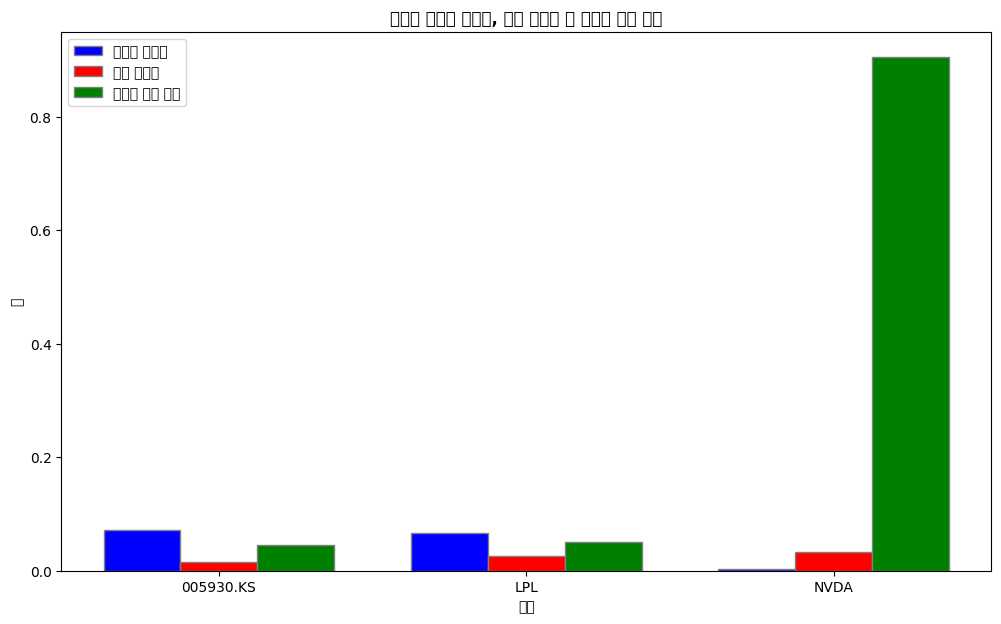


추천 주식 비중:
005930.KS: 4.61%
LPL: 4.98%
NVDA: 90.41%


In [16]:
# 사용자로부터 보유 주식 입력 받기
stock_list = input("보유하고 있는 주식의 티커 목록을 쉼표로 구분하여 입력하세요 (예: AAPL, GOOGL, MSFT): ").split(",")
stock_list = [stock.strip() for stock in stock_list]

import yfinance as yf

# 주식 데이터 가져오기
def fetch_data(tickers):
    data = {}
    for ticker in tickers:
        stock_data = yf.Ticker(ticker)
        data[ticker] = stock_data.history(period="1y")  # 최근 1년간의 데이터 가져오기
    return data

stock_data = fetch_data(stock_list)

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 수익률 및 변동성 계산
returns = {}
for stock, data in stock_data.items():
    prices = data['Close'].values.astype(float)
    daily_returns = prices[1:] / prices[:-1] - 1
    returns[stock] = daily_returns

# LSTM 모델 학습을 위한 데이터 준비
look_back = 5
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# LSTM 모델 학습
models = {}
for stock, daily_returns in returns.items():
    # 데이터 정규화
    scaler = MinMaxScaler(feature_range=(0, 1))
    daily_returns = scaler.fit_transform(daily_returns.reshape(-1, 1))

    # 데이터 분할
    train_size = int(len(daily_returns) * 0.67)
    test_size = len(daily_returns) - train_size
    train, test = daily_returns[0:train_size, :], daily_returns[train_size:len(daily_returns), :]

    # LSTM에 필요한 데이터 형식으로 변환
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # LSTM 모델 구성
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

    # 모델 저장
    models[stock] = model

print("모든 주식에 대한 LSTM 모델 학습이 완료되었습니다.")


import numpy as np
from scipy.optimize import minimize

# 각 주식의 예측된 변동성 계산
predicted_volatilities = {}
for stock, model in models.items():
    last_sequence = returns[stock][-look_back:]
    scaled_sequence = scaler.transform(last_sequence.reshape(-1, 1))
    predicted_return = model.predict(scaled_sequence.reshape(1, look_back, 1))
    predicted_volatility = scaler.inverse_transform(predicted_return)[0][0]
    predicted_volatilities[stock] = predicted_volatility

# 리스크 기여도를 동일하게 하는 최적의 주식 비중 계산 함수
def risk_parity_objective(weights, volatilities):
    # 각 주식의 리스크 기여도 계산
    risk_contributions = [vol * weight for vol, weight in zip(volatilities, weights)]
    total_portfolio_volatility = np.sum(risk_contributions)
    risk_contributions = [rc / total_portfolio_volatility for rc in risk_contributions]

    # 리스크 기여도 간의 편차를 최소화하는 것이 목표
    target_risk_contribution = 1 / len(volatilities)
    return sum([(rc - target_risk_contribution)**2 for rc in risk_contributions])

# 최적화 시작
initial_weights = [1/len(stock_list) for _ in stock_list]
bounds = [(0, 1) for _ in stock_list]
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
optimized = minimize(risk_parity_objective, initial_weights, args=(list(predicted_volatilities.values()),),
                     method='SLSQP', bounds=bounds, constraints=constraints)

# 최적의 주식 비중 출력
optimal_weights = optimized.x
print("최적의 주식 비중:")
for stock, weight in zip(stock_list, optimal_weights):
    print(f"{stock}: {weight:.2f}")

    import matplotlib.pyplot as plt

# 실제 변동성 계산
actual_volatilities = {stock: data['Close'].pct_change().std() for stock, data in stock_data.items()}

# 그래프 그리기
stocks = list(stock_data.keys())
predicted_vols = [predicted_volatilities[stock] for stock in stocks]
actual_vols = [actual_volatilities[stock] for stock in stocks]
weights = [weight for weight in optimal_weights]

barWidth = 0.25
r1 = np.arange(len(stocks))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(12,7))

# 바 차트 생성
plt.bar(r1, predicted_vols, width=barWidth, color='blue', edgecolor='grey', label='예측된 변동성')
plt.bar(r2, actual_vols, width=barWidth, color='red', edgecolor='grey', label='실제 변동성')
plt.bar(r3, weights, width=barWidth, color='green', edgecolor='grey', label='최적의 주식 비중')

# 그래프 제목 및 축 이름 설정
plt.title('주식별 예측된 변동성, 실제 변동성 및 최적의 주식 비중', fontweight='bold')
plt.xlabel('주식', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(stocks))], stocks)
plt.ylabel('값', fontweight='bold')

# 범례 표시
plt.legend()

# 그래프 표시
plt.show()

def recommend_weights(optimal_weights, stocks):
    print("\n추천 주식 비중:")
    for stock, weight in zip(stocks, optimal_weights):
        print(f"{stock}: {weight:.2%}")

recommend_weights(weights, stocks)


In [17]:
print(predicted_volatility, actual_volatilities)

0.0036807635 {'005930.KS': 0.01452299748430584, 'LPL': 0.025597889466783548, 'NVDA': 0.03381753063933791}
